In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2


# from skimage import io
import pandas as pd
import shutil

### Train_test_split

In [2]:
# data_images_names = os.listdir('./data_semantics/training/image_2/')
# print(len(data_images_names))
# data_masks_names = os.listdir('./data_semantics/training/semantic_rgb/')
# print(len(data_masks_names))

In [3]:
# data_masks_names = np.sort(data_masks_names).tolist()
# data_masks_names.remove(data_masks_names[0])
# data_masks_names

In [4]:
# print(len(data_images_names))
# print(len(data_masks_names))

In [5]:
# train_images_names, val_images_names, train_masks_names, val_masks_names = \
#                     train_test_split(data_images_names, data_masks_names, test_size=0.3, shuffle=True)

In [6]:
# len(train_images_names) 

In [7]:
# if not os.path.exists('./train_val_dataset_semantic/train/images'):
#     os.makedirs('./train_val_dataset_semantic/train/images')
    
# if not os.path.exists('./train_val_dataset_semantic/train/masks'):
#     os.makedirs('./train_val_dataset_semantic/train/masks')    

# if not os.path.exists('./train_val_dataset_semantic/val/images'):
#     os.makedirs('./train_val_dataset_semantic/val/images')
    
# if not os.path.exists('./train_val_dataset_semantic/val/masks'):
#     os.makedirs('./train_val_dataset_semantic/val/masks')

In [8]:
# Filling the folders for train and validation

# for name in train_images_names:
#     source = './data_semantics/training/image_2/' + name
#     destination = './train_val_dataset_semantic/train/images/' + name
#     Path(source).rename(destination)

# for name in train_masks_names:
#     source = './data_semantics/training/semantic_rgb/' + name
#     destination = './train_val_dataset_semantic/train/masks/' + name
#     Path(source).rename(destination)

# for name in val_images_names:
#     source = './data_semantics/training/image_2/' + name
#     destination = './train_val_dataset_semantic/val/images/' + name
#     Path(source).rename(destination)
    
# for name in val_masks_names:
#     source = './data_semantics/training/semantic_rgb/' + name
#     destination = './train_val_dataset_semantic/val/masks/' + name
#     Path(source).rename(destination)

(375, 1242, 3)


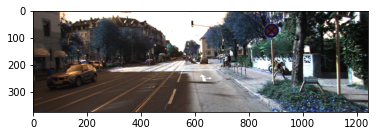

In [9]:
image = cv2.imread('./train_val_dataset_semantic/train/images/000001_10.png')
print(image.shape)
plt.imshow(image)

### Dataloader

In [10]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.images_names = np.sort(os.listdir(images_folder))
        self.masks_names = np.sort(os.listdir(masks_folder))
        
        self.img_transform = img_transform
        self.masks_transform = masks_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = Image.open(os.path.join(self.images_folder,
                                            self.images_names[idx])).convert('RGB')
        item_mask = Image.open(os.path.join(self.masks_folder,
                                              self.masks_names[idx])).convert('RGB')
        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)
        if self.masks_transform is not None:  
            random.seed(SEED)
            item_mask = self.masks_transform(item_mask)

        return item_image, item_mask

In [11]:
trans1 = transforms.Compose([
    transforms.Resize((120, 400)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])
trans2 = transforms.Compose([
    transforms.Resize((120, 400)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_set = MyDataset(images_folder = './train_val_dataset_semantic/train/images', 
                      masks_folder = './train_val_dataset_semantic/train/masks',
                      img_transform = trans1, masks_transform = trans2)
val_set = MyDataset(images_folder = './train_val_dataset_semantic/val/images', 
                      masks_folder = './train_val_dataset_semantic/val/masks',
                      img_transform = trans1, masks_transform = trans2)

In [14]:
print(len(train_set.images_names))
print(len(train_set.masks_names))
print(len(val_set.images_names))
print(len(val_set.masks_names))

140
140
60
60


In [15]:
# train_set.images_names = train_set.images_names[train_set.images_names != '.ipynb_checkpoints']

In [16]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = 8
batch_size_val = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 140, 'val': 60}

torch.Size([8, 3, 120, 400]) torch.Size([8, 3, 120, 400])
0.0 1.0 0.32896772 0.31776726
0.0 1.0 0.41039652 0.23333262


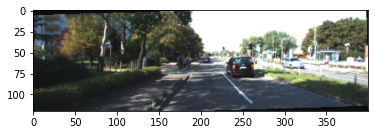

In [17]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

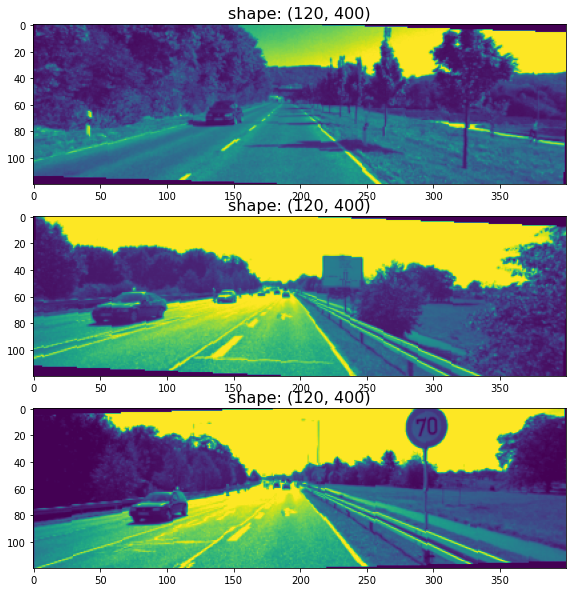

In [18]:
import torchvision.utils

n_pics_to_show = 3
inputs, masks = next(iter(dataloaders['train']))
# inputs = inputs[:n_pics_to_show]
# masks = masks[:n_pics_to_show]
# # pic = inputs[1]
# # pic_np = pic.data.numpy()[0]
# # plt.imshow(pic_np)
fig, ax = plt.subplots(n_pics_to_show, 1, figsize=(15, 10))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i]
    
    pic_np = pic.data.numpy()[0]
    ax[i].imshow(pic_np)
    ax[i].set_title('shape: {}'.format(pic_np.shape), fontsize=16)

### Model

In [19]:
from collections import defaultdict
import torch.nn.functional as F
from loss_dice import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    epoches = []
    
    metrics_dice_train = []
    metrics_dice_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)    

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
#                     print(inputs.shape)
                    outputs = model(inputs)
#                     print(outputs.shape)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            
            if phase == 'train':
                metrics_dice_train.append(metrics['dice']/epoch_samples)
            if phase == 'val':
                metrics_dice_val.append(metrics['dice']/epoch_samples)
                
            epoch_loss = metrics['loss'] / epoch_samples

            
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_dice_train, metrics_dice_val

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import unet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = unet.UNet(num_class).to(device)

# Optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model, dice_train, dice_val = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40) 

cuda:0
Epoch 0/39
----------
LR 0.0001
train: bce: 0.688725, dice: 0.554761, loss: 0.621743
val: bce: 0.697564, dice: 0.544418, loss: 0.620991
saving best model
0m 6s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.693682, dice: 0.539648, loss: 0.616665
val: bce: 0.687479, dice: 0.536458, loss: 0.611969
saving best model
0m 6s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.689620, dice: 0.533390, loss: 0.611505
val: bce: 0.689978, dice: 0.529761, loss: 0.609870
saving best model
0m 6s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.690270, dice: 0.529864, loss: 0.610067
val: bce: 0.685260, dice: 0.537510, loss: 0.611385
0m 6s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.686224, dice: 0.529160, loss: 0.607692
val: bce: 0.683862, dice: 0.526869, loss: 0.605365
saving best model
0m 6s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.681256, dice: 0.527484, loss: 0.604370
val: bce: 0.681602, dice: 0.523196, loss: 0.602399
saving best model
0m 6s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.68142

(3, 3, 120, 400)


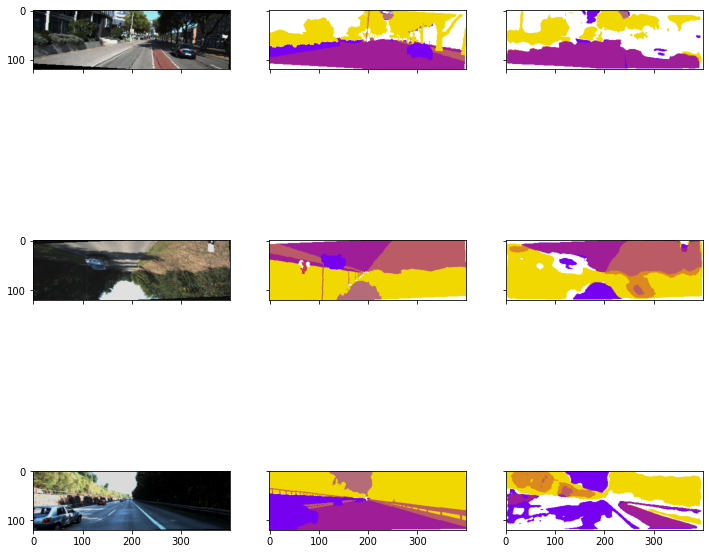

In [35]:
# prediction

import math
import helper_semantic

model.eval()  

val_batch = torch.utils.data.DataLoader(val_set,
                                            batch_size=3,
                                            shuffle=True)
        
inputs, labels = next(iter(val_batch))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

target_masks_rgb = [helper_semantic.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper_semantic.masks_to_colorimg(x) for x in pred]

helper_semantic.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])